<a href="https://colab.research.google.com/github/StevenXDiaz/AstroPersonalWebsite/blob/main/MSE_233_PSET_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MS&E 233 (Spring 2025): Homework 8 (due Jun 5th, 08:00pm)

In this homework, we will implement Econometrics for First Price Auctions. We will learn CDFs and PDFs of values from bids in a first price auction. We will apply this to synthetic data and (bonus) to a real world government auction data set from oil companies bidding for drilling rights.

# Data Generation: Samples from a First Price Auction Bids

We first define a function that generates first price auction bidding data for different distributions of values. The logic here is basically what you were asked to implement in homework 6. You don't need to implement anything here, just need to execute it. You can take a look at homework 6 if you want to understand the code here.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [2]:
def data_generative_functions(dist='uniform'):

    ###########
    # For uniform distribution of values we know everything in closed form
    ###########
    if dist == 'uniform':
        gen_values = lambda ns, nb: np.random.uniform(0, 1, (ns, nb))
        true_F = lambda v: np.clip(v, 0, 1)
        true_f = lambda v: 1.0 * ((v >=0) & (v <=1))
        true_G = lambda b: np.clip(b / (1 - 1/n_bidders), 0, 1)
        true_g = lambda b: 1.0 * ((b >=0) & (b <=(1 - 1/n_bidders))) / (1 - 1/n_bidders)

        def gen_data(n_samples, n_bidders):
            v = gen_values(n_samples, n_bidders)
            b = (1 - 1/n_bidders) * v
            return v, b

        return gen_data, gen_values, true_F, true_f, true_G, true_g

    ###########
    # For other distributions we use the characterization that each bidder
    # submits the expected maximum other bid, conditional on the event that
    # they win with their current value. And we approximate this via sampling.
    ###########
    if dist == 'lognorm':
        dist = scipy.stats.lognorm
        params = {'s': 1.0, 'loc': 0.0}
    elif dist == 'chi2':
        dist = scipy.stats.chi2
        params = {'df': 2}
    elif dist == 'expon':
        dist = scipy.stats.expon
        params = {'loc': 1.0, 'scale': 2.0}
    elif dist == 'weibull':
        dist = scipy.stats.weibull_min
        params = {'c': 5}
    else:
        raise NotImplementedError()

    def gen_values(n_samples, n_bidders):
        return dist.rvs(**params, size=(n_samples, n_bidders))

    def true_F(v):
        return dist.cdf(v, **params)

    def true_f(v):
        return dist.pdf(v, **params)

    true_G = None
    true_g = None

    def fpa_strategy(v, n_bidders):
        other_values = gen_values(100000, n_bidders - 1)
        max_other_value = np.max(other_values, axis=1)
        prob_win = np.mean(max_other_value < v)
        if prob_win == 0:
            return 0
        return np.mean(max_other_value * (max_other_value < v)) / prob_win

    def fpa_strategy_on_grid(vgrid, n_bidders):
        return np.array([fpa_strategy(v, n_bidders) for v in vgrid])

    def gen_data(n_samples, n_bidders):
        v = gen_values(n_samples, n_bidders)

        vpop = gen_values(100000, 1)
        vgrid1 = np.linspace(0, np.percentile(vpop, 99), 500)
        vgrid2 = np.linspace(np.percentile(vpop, 99), np.max(vpop), 500)
        vgrid = np.concatenate((vgrid1, vgrid2))
        fpa_strategies_grid = fpa_strategy_on_grid(vgrid, n_bidders)
        vgrid = np.concatenate((vgrid, [np.inf]))
        fpa_strategies_grid = np.concatenate((fpa_strategies_grid, fpa_strategies_grid[-1:]))

        b = np.zeros((n_samples, n_bidders))
        for i in range(n_bidders):
            inds = np.searchsorted(vgrid, v[:, i])
            b[:, i] = fpa_strategies_grid[inds]

        return v, b

    return gen_data, gen_values, true_F, true_f, true_G, true_g

# 1. Methods for Estimating CDFs and PDFs

In this section we will estimate the CDF and PDF of a distribution. EmpiricalCDF estimates the cdf and MyKernelDensity estimated the pdf. As before, you don't need to implement anything, just understand the logic and execute the cells.

In [3]:
class EmpiricalCDF:
    '''
    A class that estimates an empirical CDF from samples.
    '''

    def fit(self, y):
        '''
        y: shape (n_samples, n_dims)
            The samples. Samples flattened and are all considered to be
            i.i.d. samples from the same distribution.
        '''
        # Flatten the samples to an array of n_samples * n_dims
        y = y.flatten()
        # Order the samples in increasing order. These correspond to
        # the points were the empirical CDF will be changing
        quantiles = np.sort(y)
        # For each of these points these points the value of the empirical
        # CDF is the fraction of points below
        probs = np.arange(1, quantiles.shape[0] + 1) / quantiles.shape[0]
        # We also append a negative infinity and a plus infinity
        # to the quantiles, that will be useful at predict time
        quantiles = np.concatenate(([-np.inf], quantiles, [np.inf]))
        # The empirical CDF at negative infinity is 0 and plus infinity is 1
        probs = np.concatenate(([0], probs, [1]))
        # We store quantiles and associated probabilities as class parameters
        self.quantiles = quantiles
        self.probs = probs
        return self

    def predict(self, z):
        '''
        z: shape (n_samples,)
            The points at which to evaluate the empirical CDF.
        '''
        # for each z[i], we find the index inds[i] of the quantile array
        # such that quantiles[inds[i]-1] <= z[i] < quantiles[inds[i]]
        # Hint: use np.searchsorted(....)
        inds = np.searchsorted(self.quantiles, z, side='right')
        # Then the value of the empirical CDF at z[i] is probs[inds[i]-1]
        return self.probs[inds - 1]

In [4]:
class MyKernelDensity:
    '''
    A class that estimates a kernel density estimate from samples using a simple
    box kernel and a bandwidth that decays at some rate with the number of
    samples. Assumes samples are supported only on the non-negative reals.
    See e.g. Slide 32 in Lecture 15.
    '''

    def __init__(self, alpha=1/4):
        '''
        alpha: float
            The rate at which the bandwidth decays, i.e.
            bandwidth = std(samples) / (n_samples**(alpha))
        '''
        self.alpha = alpha

    def fit(self, y):
        '''
        y: shape (n_samples, n_dims)
            The samples. They are flattened and are all considered to be
            i.i.d. samples from the same distribution.
        '''
        # flatten the samples
        print(y.shape)
        y = y.flatten()
        print(y.shape)
        # calculate the bandwidth as a function of the standard deviation of
        # the samples and the rate of decay, using the specified alpha
        self.bandwidth = np.std(y) / (y.shape[0]**(self.alpha))
        # store the samples to be used when calculating the density at predict
        self.y_ = y.copy()
        return self

    def predict(self, z):
        '''
        z: shape (n_samples,)
            The points at which to evaluate the kernel density estimate.
        '''
        # flatten z
        z = z.flatten()
        # out will store the kernel density estimate for each z[i] point
        out = np.zeros(z.shape[0])
        # for each z[it] point
        for it in range(z.shape[0]):
            # if negative then return zero density
            if z[it] < 0.0:
                continue
            # if positive then identify whether a point in the samples `y_`
            # lies within the interval [z[it] - bandwidth, z[it] + bandwidth]
            # or outside
            in_interval = (self.y_ <= z[it] + self.bandwidth)
            in_interval &= (self.y_ >= z[it] - self.bandwidth)
            # calculate as density estimate to be the fraction of the points
            # in y_ that lie in this interval, divided by the total length
            # of the interval
            out[it] = np.mean(1.0 * in_interval) / (2*self.bandwidth)
        return out

(1000,)
(1000,)


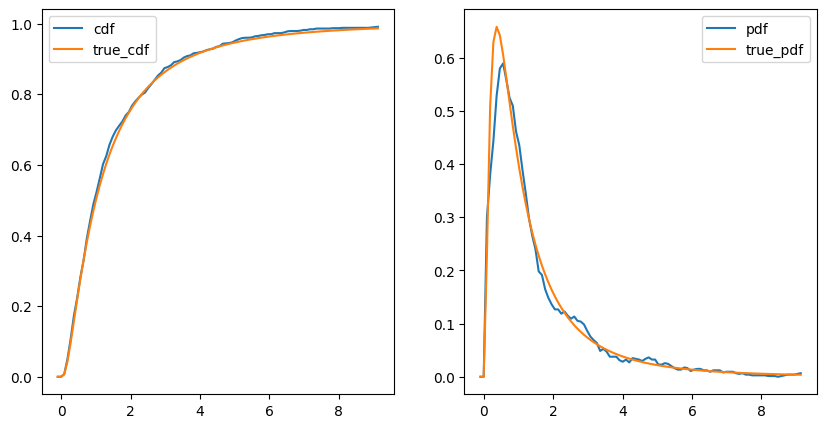

In [5]:
# Let's test out these methods
np.random.seed(123)
# generate data from the log-normal distribution
samples = scipy.stats.lognorm.rvs(s=1.0, loc=0.0, size=1000)
# fit an empirical CDF
cdf = EmpiricalCDF().fit(samples)
# fit a kernel density estimate of the pdf
pdf = MyKernelDensity().fit(samples)

# construct a grid of points for plotting
grid = np.linspace(-.1, np.percentile(samples, 99) + .1, 100)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
# plot the empirical cdf on the grid
plt.plot(grid, cdf.predict(grid), label='cdf')
# plot the true cdf on the grid
plt.plot(grid, scipy.stats.lognorm.cdf(grid, s=1.0, loc=0.0), label='true_cdf')
plt.legend()
plt.subplot(1, 2, 2)
# plot the kernel density estimate of the pdf on the grid
plt.plot(grid, pdf.predict(grid), label='pdf')
# plot the true density on the grid
plt.plot(grid, scipy.stats.lognorm.pdf(grid, s=1.0, loc=0.0), label='true_pdf')
plt.legend()
plt.show()

**Expected Answer**

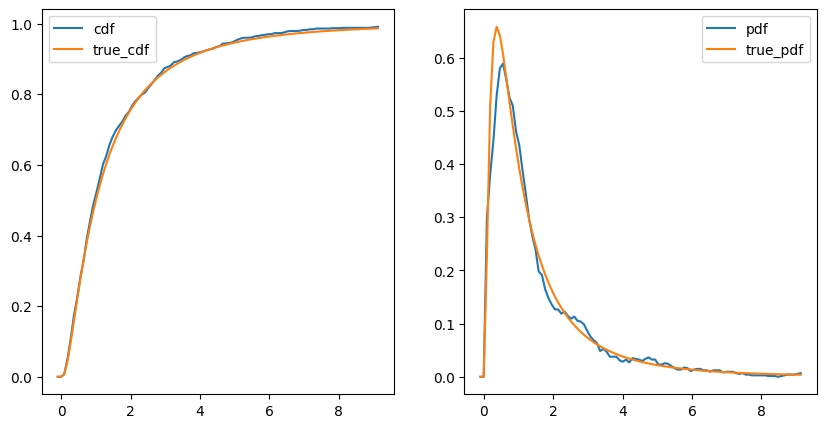

# 2. Econometrics in First Price Auctions

## 2.1 Implement CDF and PDF of Values Estimation

In [6]:
class FPAEconometrics:
    '''
    (1 points)
    Class that estimates the CDF and PDF of values and bids from bidding
    data from a First Price Auction.
    '''

    def fit(self, b):
        '''
        b: shape (n_samples, n_bidders)
            The bidding data.
        '''
        # flatten the bids, as we assume that bidders are i.i.d.
        bf = b.flatten()

        # remember the number of bidders as it is useful for bid inversion
        n_bidders = b.shape[1]

        # estimate the CDF of the bids for the flattened bids using empirical CDF
        self.Ghat = EmpiricalCDF().fit(bf)

        # estimate the pdf of the bids using kernel density estimation
        # for the bids we can use alpha=1/4 if we only assume a Lipschitz density
        # thus the bandwidth decays as n^(1/4). If we expect smoother densities
        # a larger alpha, closer to 1 can be used. But for the sake of exposition
        # let's stick to 1/4
        self.ghat =  MyKernelDensity(alpha=1/4).fit(bf)

        # construct the estimates of the values of each bidder using
        # their bids and the bid inversion formula (e.g. the reverse engineer
        # formula, that given a bid tells us what value must have submitted this
        # bid)
        estCDF = self.Ghat.predict(bf)
        estPDF = self.ghat.predict(bf)
        self.vfhat =  bf + estCDF / estPDF * (1.0 / (n_bidders - 1))

        # use these estimates values as samples of values
        # estimate the CDF of values using the empirical CDF
        self.Fhat = EmpiricalCDF().fit(self.vfhat)

        # estimate the pdf of values using kernel density estimation
        # for the values, we will have to use a slower bandwidth decay
        # as theory prescribes as n^(1/8). In practice, using something slower
        # than n^(1/4) but not as slow as n^(1/8) would do better; but for
        # the sake of exposition, let's stick to 1/8
        self.fhat =  MyKernelDensity(alpha=1/8).fit(self.vfhat)

        # return self for convenience
        return self

    def cdf_bids(self, z):
        '''
        z: shape (n_samples,)
            The points at which to evaluate the CDF of bids.
        '''
        return self.Ghat.predict(z)

    def pdf_bids(self, z):
        '''
        z: shape (n_samples,)
            The points at which to evaluate the pdf of bids.
        '''
        return self.ghat.predict(z)

    def cdf_values(self, z):
        '''
        z: shape (n_samples,)
            The points at which to evaluate the CDF of values.
        '''
        return self.Fhat.predict(z)

    def pdf_values(self, z):
        '''
        z: shape (n_samples,)
            The points at which to evaluate the pdf of values.
        '''
        return self.fhat.predict(z)

In [7]:
def plot_values(grid, est_F, est_f, true_F, true_f):
    '''
    Plot the estimated and true CDFs and PDFs of values
    using the provided grid of points.
    '''
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(grid, est_F(grid), label='Fhat')
    plt.plot(grid, true_F(grid), label='F')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(grid, est_f(grid), label='fhat')
    plt.plot(grid, true_f(grid), label='f')
    plt.legend()
    plt.show()

In [8]:
def errors(grid, est_F, est_f, true_F, true_f):
    '''
    (0.5 points)
    Calculate the maximum absolute error in the estimated CDF and pdf of values
    using the provided grid of points.
    '''
    # calculate the maximum absolute error of the CDF on the grid
    eF = np.max( np.abs(true_F(grid) - est_F(grid)) )

    # calcualte the maximum absolute error of the pdf on the grid
    ef = np.max(np.abs(true_f(grid) - est_f(grid)))

    return eF, ef

In [9]:
'''
We define the generative functions for the distribution that we want to examine
The distributions are one of {'uniform', 'lognorm', 'chi2', 'expon', 'weibull'}

Fill free to experiment with other distributions beyond lognorm, just to see
how well the process behaves across distributions, but report your results only
for lognorm

Returns:
  gen_data: (n_samples, n_bidders) -> samples of values and associated FPA bids
  gen_values: (n_samples, n_bidders) -> samples of values
  true_F: points -> true CDF of values function
  true_f: points -> true pdf of values function
  true_G: points -> true CDF of bids function (if dist not 'uniform' then None)
  true_g: points -> true pdf of bids function (if dist not 'uniform' then None)
'''
gen_data, gen_values, true_F, true_f, true_G, true_g = data_generative_functions('lognorm')

In [10]:
np.random.seed(123)

# generate FPA data with n_samples, n_bidders
n_samples = 5000
n_bidders = 2
v, b = gen_data(n_samples, n_bidders)

# draw a very large population of values to be used to construct
# a grid of points with respect to which to calculate the errors
vpop = gen_values(1000000, 1)
grid = np.linspace(-.1, np.percentile(vpop, 95) + .1, 100)

(10000,)
(10000,)
(10000,)
(10000,)
eF=0.0198, ef=0.306


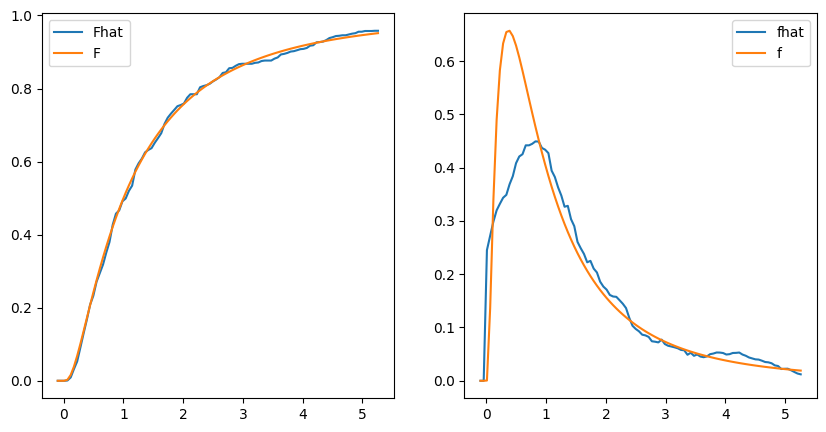

In [11]:
np.random.seed(123)

# instantiate an FPA econometrics object
metrics = FPAEconometrics()
# fit it to the bidding data you have already generated
metrics.fit(b)
# calculate the maximum absolute error of the estimated CDF and pdf of values
eF, ef = errors(grid, metrics.cdf_values, metrics.pdf_values, true_F, true_f)
print(f'eF={eF:.3}, ef={ef:.3}')
# plot the estimated vs true CDF and pdf of values
plot_values(grid, metrics.cdf_values, metrics.pdf_values, true_F, true_f)

**Expected Answer**

```
eF=0.0198, ef=0.306
```

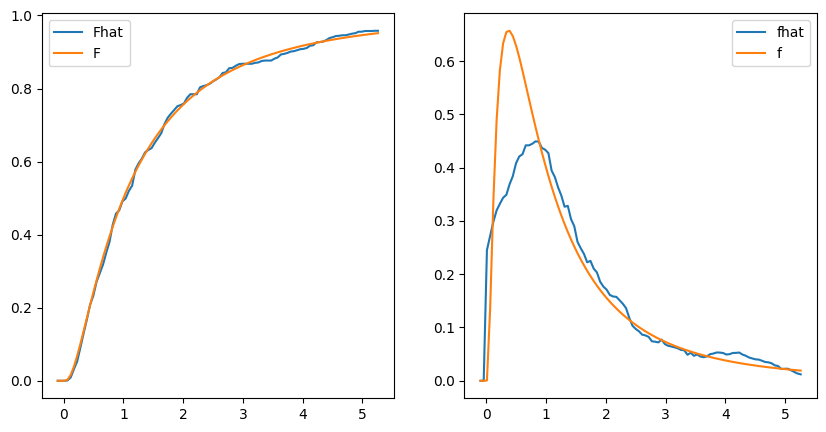

### What if we had Truthful Samples

It is interesting to compare what results we would have gotten had we run a Second Price Auction historically and had collected truthful value samples. Then we directly have access to the samples `v` and not just to bids `b`.

(10000,)
(10000,)
eF=0.00737, ef=0.152


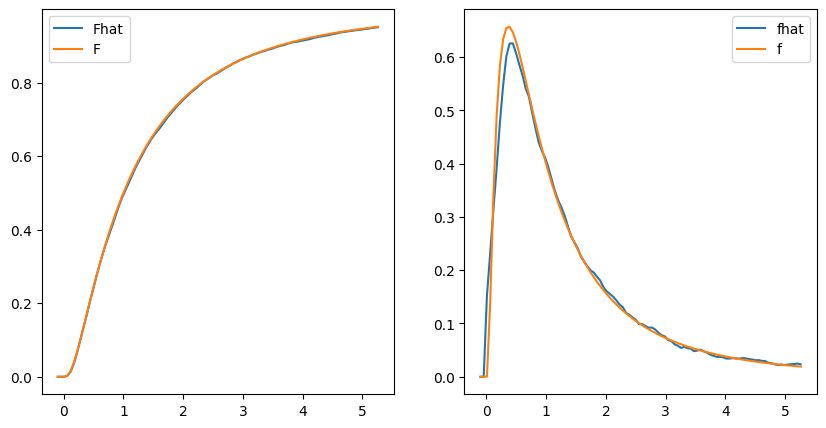

In [12]:
np.random.seed(123)

def generate_truthful_functions(vf):
    '''
    (0.5 point)
    estimate the CDF and pdf of values using the sampled flattened true values `vf`
    '''

    # empirical CDF of values, if we had access to the truthful samples vf
    Fhat_truthful = EmpiricalCDF().fit(vf)

    # kernel density estimate of pdf of values, if we had access to the truthful samples
    # since we have direct truthful samples, we should use alpha=1/4 for the bandwidth
    fhat_truthful = MyKernelDensity(alpha=1/4).fit(vf)
    return Fhat_truthful, fhat_truthful

# flatten v first
vf = v.flatten()

Fhat_truthful, fhat_truthful = generate_truthful_functions(vf)

# calculate the maximum absolute error of the estimated CDF and pdf of values
eF, ef = errors(grid, Fhat_truthful.predict, fhat_truthful.predict, true_F, true_f)
print(f'eF={eF:.3}, ef={ef:.3}')
# plot the estimated vs true CDF and pdf of values
plot_values(grid, Fhat_truthful.predict, fhat_truthful.predict, true_F, true_f)

**Expected Answer**

```
eF=0.00737, ef=0.152
```

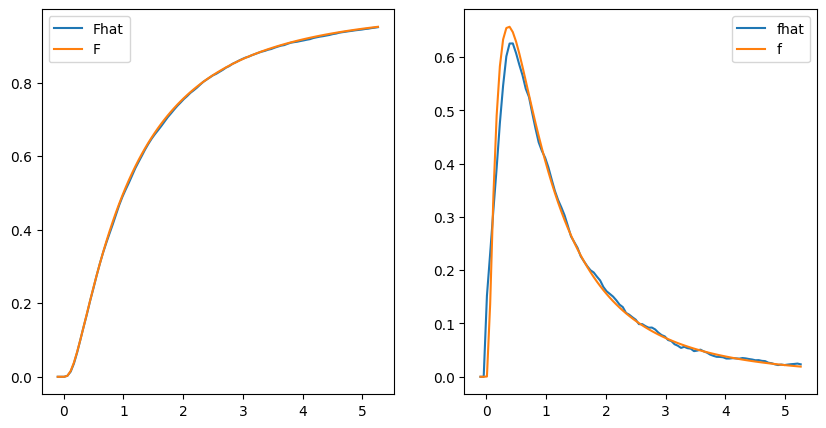

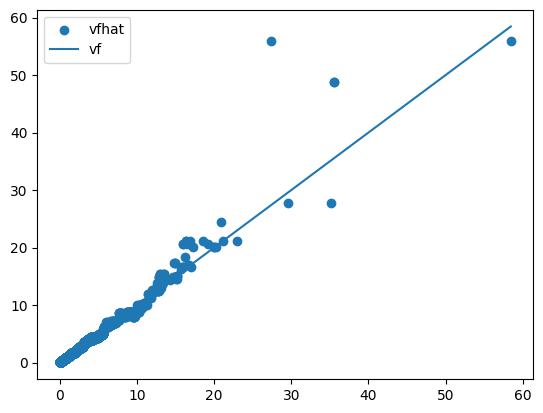

In [13]:
# Let's examine how close are the true values to the estimated values
# by our bid inversion formula. These should be close to each other
plt.scatter(vf, metrics.vfhat, label='vfhat')
plt.plot(np.sort(vf), np.sort(vf), label='vf')
plt.legend()
plt.show()

**Expected Answer**

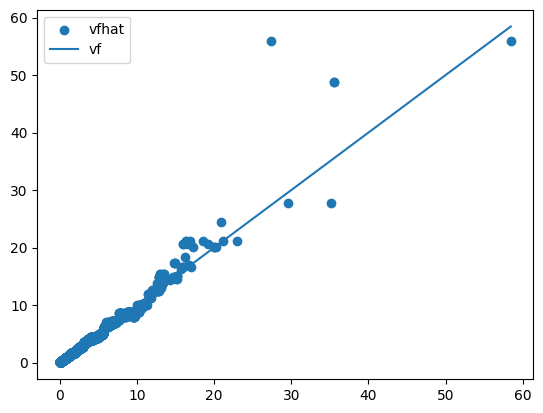

In what region of values do you see larger errors in the estimated value based on bid inversion?

[Place your answer here]

The errors were the largest in magnitude in the regions where we just didn't have enough data points to make precise estimates -- aka the tails of the of our data.

### More adaptive bandwidth selection

Our choice of bandwidth was too conservative and not very adaptive to the true smoothness properties of the density. There are many data-driven methods for choosing a bandwidth and even methods that choose a different bandwidth for different regions of values, based on local smoothness properties. We will use one of them as implemented in the awkde package.

Moreover, this package will use the more well behaved Gaussian kernel and not the box kernel that we used in our implementation. Other packages you can use out there are `KernelDensity` from `scikit-learn`, or `guassian_kde` from `scipy.stats` or the methods implemented in the `KDEpy` package.

For simplicity, we will simply re-implement the `MyKernelDensity` class. Then the `FPAEconometrics` class will then be using this implementation every time we call it in subsequent cells and we dont need to redefine `FPAEconometrics`.

In [14]:
# this gets the package from github and installs it locally
!git clone https://github.com/mennthor/awkde
!pip install ./awkde

fatal: destination path 'awkde' already exists and is not an empty directory.
Processing ./awkde
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for awkde: filename=awkde-0.1-cp311-cp311-linux_x86_64.whl size=81033 sha256=2801231dd0011623bae756538cfb9f18523365cc7abd04ae38296d94a86a62ef
  Stored in directory: /tmp/pip-ephem-wheel-cache-v3ih6vw5/wheels/10/b7/be/e04133a09f360ce616e3b43d912811ed99024a9bb591eaa6d4
Successfully built awkde
  Attempting uninstall: awkde
    Found existing installation: awkde 0.1
    Uninstalling awkde-0.1:
      Successfully uninstalled awkde-0.1


In [15]:
from awkde import GaussianKDE

class MyKernelDensity:
    '''
    Kernel density with local adaptive bandwidth selection
    '''

    def __init__(self, alpha=1/4):
        ''' The alpha here is only for consistency of API with the prior
        MyKernelDensity class. It is not used in this class. '''
        self.alpha = alpha

    def fit(self, y):
        y = y.reshape(-1, 1)
        self.kd = GaussianKDE(glob_bw="silverman", alpha=0.5, diag_cov=True)
        self.kd.fit(y)
        return self

    def predict(self, z):
        z = z.flatten()
        out = self.kd.predict(z.reshape(-1, 1))
        out[z < 0.0] = 0 # we zero out density in the negative reals
        return out

eF=0.015, ef=0.214


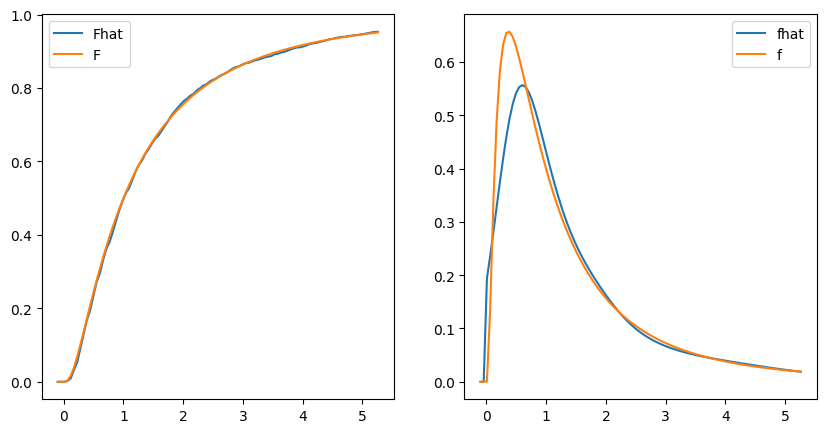

In [16]:
np.random.seed(123)

# instantiate an FPA econometrics object
metrics = FPAEconometrics()
# fit it to the bidding data you have already generated
metrics.fit(b)
# calculate the maximum absolute error of the estimated CDF and pdf of values
eF, ef = errors(grid, metrics.cdf_values, metrics.pdf_values, true_F, true_f)
print(f'eF={eF:.3}, ef={ef:.3}')
# plot the estimated vs true CDF and pdf of values
plot_values(grid, metrics.cdf_values, metrics.pdf_values, true_F, true_f)

**Expected Answer**

```
eF=0.015, ef=0.214
```

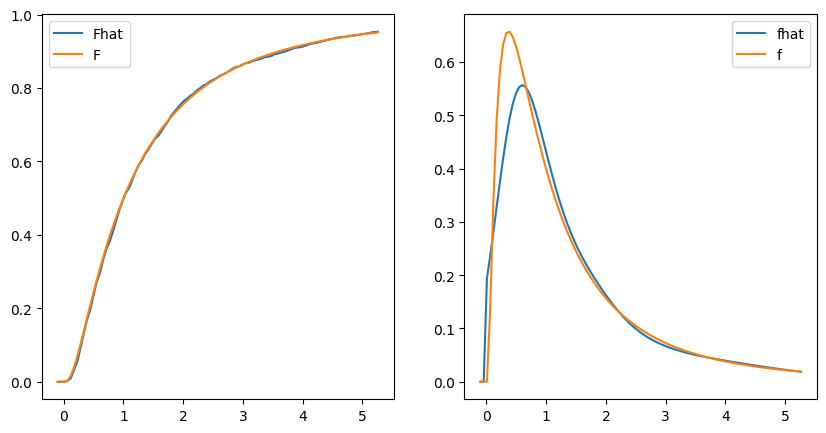

## 2.2 Finding Optimal Reserves

Now we will use the estimated value distribution to find what would be the revenue had we run a second price auction.

We also find optimal reserve prices for a second price auction with a single reserve for all bidders.

In [17]:
# we calculate the FPA revenue using the sampled bid profiles
def calculate_revenues(b, metrics):
    '''
    (0.5 points)
    '''
    # we calculate the FPA revenue using the sampled bid profiles
    n_bidders = b.shape[1]
    fpa_rev = np.mean(np.max(b, axis=1))

    # we calculate what would have been the SPA revenue using the recovered
    # estimated value profiles in the metrics object, based on bid inversion.
    # Note that `vfhat` in the metrics object is flattened, but if we reshape it
    # to (n_samples, n_bidders), then these would correspond to the recovered values
    # for each of the bidders in each of the sampled auctions.
    reshapedVfhat = metrics.vfhat.reshape(-1, n_bidders)
    reshapedAndSorted = np.sort(reshapedVfhat, axis=1)[:, -2]
    spa_rev = np.mean(reshapedAndSorted)

    return fpa_rev, spa_rev


fpa_rev, spa_rev = calculate_revenues(b, metrics)

print(f"FPA Revenue: {fpa_rev:.3f}")

print(f"SPA Revenue: {spa_rev:.3f}")

FPA Revenue: 0.794
SPA Revenue: 0.817


**Expected Answer**

```
FPA Revenue: 0.794
SPA Revenue: 0.817
```

In this setting, from theory, do we expect the FPA revenue to be greater, smaller or equal to the SPA revenue? Comment on the empirical results above based on your answer. Are they roughly consistent with the theory?

[Place your answer here]

We expect SPA to be greater than FPA, which is matched by the empirical resuts above, so yes, they are roughly consistent with the theory.

In [18]:
def SPAr_revenue(values, r):
    '''
    (0.5 points)
    Calculate revenue of SPA auction with reserve r for each of the sampled
    value vectors in `values`
        values: shape (n_samples, n_bidders)
    '''
    # sort the bidders in each sampled auction in increasing order
    sorted_values = np.sort(values, axis=1)
    # calculate the revenue of each sampled auction as the maximum of the
    # second highest bid and the reserve
    # only when the highest bid passes the reserve price r, else zero.
    highest_values = sorted_values[:, -1]
    second_highest_values = sorted_values[:, -2]
    meets_reserve = highest_values >= r
    revenues_if_met = np.maximum(second_highest_values, r)
    revs = np.where(meets_reserve, revenues_if_met, 0)
    # return the revenues for each sampled value profile
    return revs

In [19]:
def opt_reserve(values):
    ''' (0.5 points)
    Find the optimal reserve price for a second price auction with a single
    reserve for all bidders.
        values: shape (n_samples, n_bidders)
    '''
    # sort the bidders in each sampled auction in increasing order
    sorted_values = np.sort(values, axis=1)
    # search over a fine enough grid of plausible reserve price values
    grid = np.linspace(0, np.percentile(values, 95), 1000)
    best_rev = 0
    best_r = 0
    for r in grid:
        # calculate the average revenue of SPA with reserve r
        rev = SPAr_revenue(sorted_values, r).mean()
        # if this revenue is better then store this revenue and reserve
        if rev > best_rev:
            best_r = r
            best_rev = rev
    return best_r, best_rev

In [20]:
np.random.seed(123)

# calculate the optimal reserve price, using the recovered approximate values
# from bid inversion, reshaped to (n_samples, n_bidders)
values = metrics.vfhat.reshape(-1, n_bidders)
best_r, best_rev = opt_reserve(values)
print(f"Estimated Best Reserve: {best_r:.3f}")
print(f"Estimated Revenue of Estimated Best Reserve: {best_rev:.3f}")

Estimated Best Reserve: 1.094
Estimated Revenue of Estimated Best Reserve: 0.964


**Expected Answer**

```
Estimated Best Reserve: 1.094
Estimated Revenue of Estimated Best Reserve: 0.964
```

In [21]:
np.random.seed(123)
# evaluate the actual revenue of the identified reserve price on a fresh
# sample of value profiles. This simulates what revenue you would collect
# in the future if you go with this reserve price
values = gen_values(1000000, n_bidders)
true_rev = SPAr_revenue(values, best_r).mean()
print(f"True Revenue of Estimated Best Reserve: {true_rev:.3f}")
# then let's calculate what would be the revenue of the truly optimal reserve
true_best_r, true_best_rev = opt_reserve(values)
print(f"Truly Best Reserve: {true_best_r:.3f}")
print(f"True Revenue of truly best reserve: {true_best_rev:.3f}")

True Revenue of Estimated Best Reserve: 0.943
Truly Best Reserve: 1.360
True Revenue of truly best reserve: 0.952


**Expected Answer**

```
True Revenue of Estimated Best Reserve: 0.943
Truly Best Reserve: 1.360
True Revenue of truly best reserve: 0.952
```

Comment on how well we did by using the bid inversion approach, compared to the oracle that knows the population distribution?

[Place your answer here]
The true revenue of estimated best reserve method is 0.943, which is very close to the true optimal reserve of 0.952, so we did almost perfectly with the bid inversion approach.

## 2.3 Performance over Many Experiments

In [22]:
# We now examine the average performance over many experiments and for
# an increasing sample size, but for the `uniform` distribution, i.e.
# when values are distributed uniformly in [0, 1]
gen_data, gen_values, true_F, true_f, true_G, true_g = data_generative_functions('uniform')
n_bidders = 2

In [23]:
# define an experiment function so that we can run experiments in parallel
def exp(it, n_samples, n_bidders, grid, gen_data, true_F, true_f):
    np.random.seed(it)
    # sample values
    v, b = gen_data(n_samples, n_bidders)
    # fit FPA metrics object
    metrics = FPAEconometrics()
    metrics.fit(b)
    # return CDF and pdf errors
    return errors(grid, metrics.cdf_values, metrics.pdf_values, true_F, true_f)

In [24]:
from joblib import Parallel, delayed

def find_errors_grid(grid, exp, n_bidders, gen_data, true_F, true_f):
    ''' (0.5 points)'''
    # for an increasing sample size
    # (the 10000 sample case might take a couple of minutes to finish)
    sample_sizes = [100, 500, 1000, 10000]
    all_res = []
    for n_samples in sample_sizes:
        # call Parallel to run in parallel 10 experiments
        # at each call to exp, pass a different seed so that you don't get the
        # same result. So pass seed it=0, 1, 2, 3, ...
        res = Parallel(n_jobs= -1)(delayed(exp)(i, n_samples, n_bidders, grid, gen_data, true_F, true_f) for i in range(10))
        all_res.append(res)
    return sample_sizes, all_res

# define the grid of points on which to evaluate the worst-case errors
grid = np.linspace(-0.1, 1.1, 100)

sample_sizes, all_res = find_errors_grid(grid, exp, n_bidders, gen_data, true_F, true_f)

for i in range(len(sample_sizes)):
    n_samples = sample_sizes[i]
    res = all_res[i]
    # calcualte the average error in CDF and pdf across experiments
    print(f'n={n_samples}, '
          f'eF={np.mean([r[0] for r in res]):.3f}, '
          f'ef={np.mean([r[1] for r in res]):.3f}')

n=100, eF=0.115, ef=0.658
n=500, eF=0.090, ef=0.651
n=1000, eF=0.078, ef=0.663
n=10000, eF=0.056, ef=0.749


**Expected Answer**

```
n=100, eF=0.115, ef=0.658
n=500, eF=0.090, ef=0.651
n=1000, eF=0.078, ef=0.663
n=10000, eF=0.056, ef=0.749
```

In [25]:
from joblib import Parallel, delayed

# define a new grid of points on which to evaluate the worst-case errors
grid = np.linspace(.1, .9, 100)

sample_sizes, all_res = find_errors_grid(grid, exp, n_bidders, gen_data, true_F, true_f)

for i in range(len(sample_sizes)):
  n_samples = sample_sizes[i]
  res = all_res[i]
  # calcualte the average error in CDF and pdf across experiments
  print(f'n={n_samples}, '
        f'eF={np.mean([r[0] for r in res]):.3f}, '
        f'ef={np.mean([r[1] for r in res]):.3f}')

n=100, eF=0.059, ef=0.538
n=500, eF=0.036, ef=0.465
n=1000, eF=0.030, ef=0.408
n=10000, eF=0.015, ef=0.295


**Expected Answer**

```
n=100, eF=0.059, ef=0.538
n=500, eF=0.036, ef=0.465
n=1000, eF=0.030, ef=0.408
n=10000, eF=0.015, ef=0.295
```

(0.5 points) Did the worst-case errors over the grid in the CDF decrease and seem to be going towards zero in the first definition of the grid? Did the worst-case errors over the grid in the PDF decrease and seem to be going towards zero in the first definition of the grid? What about the second definition of the grid?
Which aspect of the main Theorem 1 in the [Lecture Notes](https://raw.githubusercontent.com/stanford-msande233/spring24/master/assets/presentations/lecture_notes_gpv.pdf) is relevant here for the potential difference in behavior that we observe in these two definitions of the grid over which we calculate errors?

[Place your answer here]

The worst case CDF errors approached 0 as we included more samples in both definitions of the grid, and PDF errors decreased more siginificantly in the second than the first -- results that seem to correspond with Theorem 1 from the lecture notes.

# 3. Real Data (Bonus)

This is a bonus problem with no grades, but you are welcome to submit this with your assignment.

Let's apply these methods to a real dataset.
We will be using this dataset:

https://capcp.la.psu.edu/wp-content/uploads/sites/11/2020/07/OCS_Auction_Data_Description.pdf

We have already written code for parsing the data, filtering only the auctions that have two bidders and transforming the bids to be bid-per-acreage, so that we can look at bids across different regions that were auctioned, that had different sizes. If you want you can examine the file `parse_file.py` to see all the preprocessing logic.

In [ ]:
!wget "https://www.dropbox.com/scl/fi/2zaeshyi515kp7v8bezae/Dataset.xlsx?rlkey=0akkk800qthew5rglqsifi0u9&st=d0san5ke&dl=0" -O Dataset.xlsx
!wget https://github.com/stanford-msande233/spring24/raw/master/assets/code/parse_file.py -O parse_file.py

In [ ]:
import os
import openpyxl

wb = openpyxl.load_workbook(os.path.abspath('Dataset.xlsx'))

In [ ]:
# we only focus on auctions in the Tract 79 sector
sheet1 = wb['Tract79']
sheet2 = wb['Trbid79']

In [ ]:
from parse_file import matrix_bids
import numpy as np
# Testing we have the right number of auctions for 2 bidders
nb_bidders = 2
list_bids = matrix_bids(wb, sheet1, sheet2, nb_bidders)
nb_bids = len(list_bids[0])
b = np.array(list_bids).T
# now we have the exact same input as we've been using
# each row of b contains the two bids of a bidder for an auction

In [ ]:
# we remove some outlier auctions where some bidders submitted
# a huge bid. Potentially these auctions do not follow the theorical
# paradigm. This is only a heuristic here.
thr1 = np.percentile(b.flatten(), 95)
filter = np.any(b >= thr1, axis=1)
np.sum(filter) # how many auctions we remove

In [ ]:
b = b[~filter]
b.shape[0] # how many auctions we have

In [ ]:
import matplotlib.pyplot as plt
plt.hist(b.flatten(), bins=100)
plt.show()

## 3.1 Apply FPA Econometrics to the Data

In [ ]:
# Let's run our FPA econometrics
metrics = {{FILL IN}}

In [ ]:
# Let's plot the distribution bids and values we recoevered
grid_b = np.linspace(-10, 5*np.max(b), 100)
grid_v = np.linspace(-10, 5*np.max(b), 100)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
# Plot CDF of bids on grid_b
plt.plot(grid_b, {{FILL IN}}, label='Ghat')
# Plot CDF of values values on grid_v
plt.plot(grid_v, {{FILL IN}}, label='Fhat')
plt.legend()
plt.subplot(1, 2, 2)
# pdf of bids
plt.plot(grid_b, {{FILL IN}}, label='ghat')

# pdf of values
plt.plot(grid_v, {{FILL IN}}, label='fhat')
plt.legend()
plt.show()

**Expected Answer**

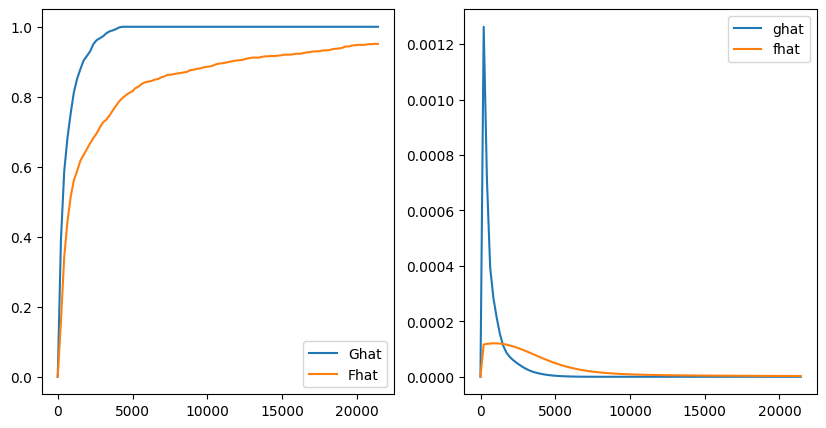

In [ ]:
# Let's print some summary statistics of bid distribution versus value distribution
print(f"Max Bid: {{{FILL IN}}:.4f}, Max Value: {{{FILL IN}}:.4f}")
print(f"Mean Bid: {{{FILL IN}}:.4f}, Mean Value: {{{FILL IN}}:.4f}")
print(f"Median Bid: {{{FILL IN}}:.4f}, Median Value: {{{FILL IN}}:.4f}")

**Expected Answer**

```
Max Bid: 4285.1816, Max Value: 126166.2227
Mean Bid: 633.6358, Mean Value: 4744.9534
Median Bid: 322.4168, Median Value: 833.0729
```


In [ ]:
# Let's plot the value as a function of the bid
plt.scatter({{FILL IN}}, {{FILL IN}})
plt.xlabel('bid')
plt.ylabel('value')
plt.show()

**Expected Answer**

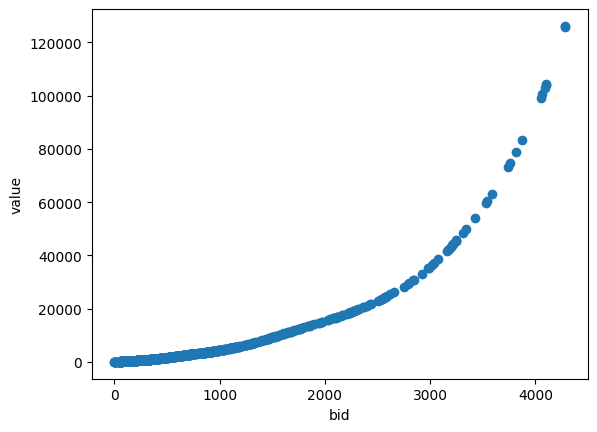

In [ ]:
# Let's plot the bid as a function of the estimated value
plt.scatter({{FILL IN}}, {{FILL IN}})
plt.xlabel('value')
plt.ylabel('bid')
plt.show()

**Expected Answer**

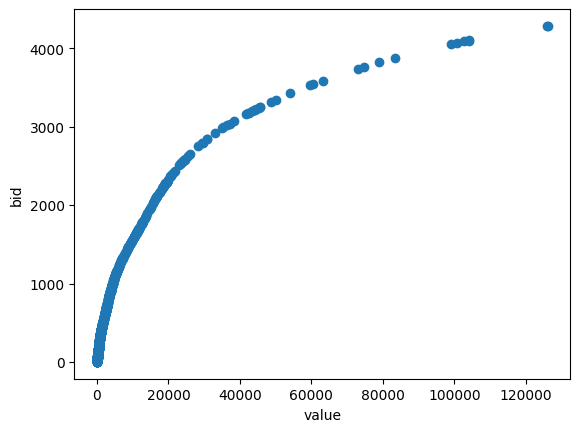

## 3.2 Calculate Revenues and Optimal Reserves

In [ ]:
# For the revenue of the FPA auction, we'll also report the standard error
# we should expect the error in our calculation to be roughly within 2*standard error
# The standard error for an empirical mean, i.e. 1/n sum_i X_i, is equal to
# std(X_1, ..., X_n) / sqrt(n). For our case, the X_i will be the revenue of
# the i-th sample of an auction (either a first-price or second price)
print(f"Revenue FPA: {{{FILL IN}}:.4f}, Std. Error: {{{FILL IN}}:.4f}")

# Similarly we calculate SPA revenue. Here the standard error does not incorporate
# the error that stems from our value approximation. So maybe we should expect
# the true error to be slightly larger than 2*standard error.
spa_rev = SPAr_revenue(metrics.vfhat.reshape(-1, n_bidders), 0)
print(f"Revenue SPA: {{{FILL IN}}:.4f}, Std. Error: {{{FILL IN}}:.4f}")

**Expected Answer**

```
Revenue FPA: 924.3195, Std. Error: 40.7594
Revenue SPA: 1547.8872, Std. Error: 166.2403
```

In [ ]:
# Let's calculate the optimal reserve price if we were to run
# a second price auction with a reserve.
values = {{FILL IN}}
best_r, best_rev = opt_reserve(values)
print(f"Optimal Second-Price Reserve {best_r:.3f}")
print(f"Optimal SPA-r Revenue: {best_rev:.3f}")

**Expected Answer**

```
Optimal Second-Price Reserve 15708.239
Optimal SPA-r Revenue: 2526.553
```

Discuss the optimal second price reserve we identified and how it compares to the mean, median and maximum bid in the distribution of bids we observed.

[Place your answer here]

## 3.3 Plausibility of basic assumptions

We should always be worried and critical about many of the assumptions we've made that enable the econometric analysis.

Our FPA Econometric analysis is making several crucial assumptions:
1. Bidders values are independently distributed across bidders for each auction
2. Bidders values are independently distributed across auctions for each bidder
3. Bidders submit bids based on a symmetric Bayes-Nash equilibrium

Discuss the plausibility of each of these assumptions.


[Place your answer here]

The above assumptions imply that the bids of bidder 1 should be independent of the bid of bidder 2 in our matrix of bids `b`. We can actually test that assumption, by checking whether the two random variables, i.e. $b[0]$ and $b[1]$ are correlated or not. One easy way to check whether these variables are independent is to run a linear regression predicting $b[1]$ as a linear function of $b[0]$. If the coefficient associated with $b[0]$ is statistically significant (e.g. the confidence interval does not contain zero), then these variables cannot be independent, and we refute the claim that bids are independently distributed.

In [ ]:
from statsmodels import api as sm

X = sm.add_constant(b[:, [0]])
model = sm.OLS(b[:, [1]], X)
results = model.fit()
print(results.summary())

Discuss the results.

[Place your answer here]